In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm, svd
import quimb as qu

/home/julieta/anaconda3/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/julieta/anaconda3/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/julieta/anaconda3/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


Steps of the algorithm:

1. INITIALIZATION: Start from a normalized random MPS with shape (1, d, chi) (chi, d, chi) (chi, d, 1)
    The Spin operators are also constructed and saved 

    
    
2. EVOLVE METHOD: $$\\$$
    requires the methods: $\\$
              time_evolution_operator-> We need the Hamiltonian 
              since the time evolution operator is $$U(t)=\exp(-iHt)$$
              
     which start initializing the Hamiltonian and if it is already initialize just takes it. Then it computes the time evolution operator   
     
    trotterize -> Since the Hamiltonian is an operator and is inside the time evolution operator which is an exponent we make use of the Trotter-Suzuki decomposition which approximates the exponent of a sum of operators with a product of exponents of the same operators as:
              $$e^{(V+W)\delta}=S^{V\delta}e^{W\delta}+\mathcal{O}(\delta^2)$$ 
      where $V$ and $W$ are operators and $\delta$ a small parameter. The second order expansion is:
      $$e^{(V+W)\delta}=e^{V\delta/2}e^{W\delta}e^{V\delta/2}+\mathcal{O}(\delta^3)$$
      So the trotterize method applies the previous to each bond via the UPDATE method
         requires: UPDATE method.
                 At each bond this method has the MPS matrix for A and the next bond being B.
                 Then A and B are contracted together and then contracted with U operator (Time evolution operator)
                 The SVD is applied to the resulting matrix
         
     
         

In [2]:
class TNet():



    def __init__(self, N, spin=1, chi=2, max_bond_dim=20):

        self.N = N
        self.spin = spin
        self.d = int(2 * self.spin + 1)
        self.chi = chi
        self.max_bond_dim = max_bond_dim
        self.norm = None
        
        """We are starting from a random MPS with open boundary conditions.
        The first and last tensors have shapes (1, d, chi) and (chi, d, 1) respectively,
        ensuring scalar contraction at the ends. The internal tensors will have shape (chi, d, chi)."""

        L = np.random.randn(1, self.d, self.chi) + 1j * np.random.randn(1, self.d, self.chi)
        R = np.random.randn(self.chi, self.d, 1) + 1j * np.random.randn(self.chi, self.d, 1)
        L /= np.linalg.norm(L)/np.sqrt(self.chi)
        R /= np.linalg.norm(R)

        self.MPS = []
        self.MPS.append(L)
        
        """Internal tensors"""
        for _ in range(N-2):
            randomized_site = np.random.randn(self.chi, self.d, self.chi) + 1j * np.random.randn(self.chi, self.d, self.chi)
            randomized_site /= np.linalg.norm(randomized_site)/np.sqrt(self.chi)
            self.MPS.append(randomized_site)
        self.MPS.append(R)
        self.get_norm()
        
        self.H = None
        self.U = None
        self.Sx, self.Sy, self.Sz = self.spin_ops()
        self.CHIs = self.chi*np.ones(self.N-1, dtype=int)
        
        
    def spin_ops(self):
        Sx = qu.spin_operator('x', self.spin)
        Sy = qu.spin_operator('y', self.spin)
        Sz = qu.spin_operator('z', self.spin)

        return Sx, Sy, Sz
    
    
    def aklt_2site_hamiltonian(self):
        """We are defining the Hamiltonian wich is translational
         invariant so we only need a cell to compute the evolution"""

        Sx, Sy, Sz = self.Sx, self.Sy, self.Sz
        
        SdotS = (
        np.einsum('ij,kl->ikjl', Sx, Sx) +
        np.einsum('ij,kl->ikjl', Sy, Sy) +
        np.einsum('ij,kl->ikjl', Sz, Sz)
        )

        SdotS = SdotS.reshape(self.d**2, self.d**2)

        H = SdotS + 1/3 * SdotS@SdotS

        return H




    def make_left_canonical(self, bond=0, mode = 'qr', verbose=False):
        """We are starting from a random MPS, which is not usually in canonical form.
        Putting tensors into canonical form makes them act as isometries, which is 
        crucial for numerical stability and efficient truncation during TEBD."""
        
        if bond < 0 or bond >= self.N - 1:
            raise ValueError(f"Bond index {bond} out of range. Must be between 0 and {self.N - 2}(inclusive).")
        
        A = self.MPS[bond]
        B = self.MPS[bond + 1]
        chiL, d, chiB = A.shape
        _, _, chiR = B.shape

        if mode == 'qr':
            
            Q, R = np.linalg.qr(A.reshape(chiL * d, chiB), mode='reduced')
            chi_new = R.shape[0]

            A_new = Q.reshape(chiL, d, chi_new)
            B_new = np.einsum('ij,jkl->ikl', R, B).reshape(chi_new, d, chiR)
            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new
            
            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond dimension {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        elif mode == 'svd':
            """One of the MPS matrix is taken and the SVD is performed taking
            its indices and then they are contracted with the next matrix. The 
            difference with the SVD to decompose in MPS is that for the latter,
            we are taking the full tensor and reshaping it so that the SVD can 
            perform in the two sections"""
            
            u, s, vh = svd(A.reshape(chiL * d, chiB), full_matrices=False)
            chi_new = min(self.max_bond_dim, len(s))
            if chi_new < len(s):
                discarded_weight = np.sum(s[chi_new:]**2)
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(s)}. \nDiscarded weight: {discarded_weight:.4f}.\nIncrease max_bond_dim if needed."
                warnings.warn(message, UserWarning)

            u = u[:, :chi_new]
            s = s[:chi_new]
            vh = vh[:chi_new, :]

            svh = np.diag(s) @ vh

            A_new = u.reshape(chiL, d, chi_new)
            B_new = np.einsum('ij,jkl->ikl', svh, B).reshape(chi_new, d, chiR)
            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'qr' or 'svd'.")



    def is_left_canonical(self, site=0, all=False):
            """Check the isometry: A† A = I"""
            
            if all:
                left_can_list = [self.is_left_canonical(s, all=False) for s in range(self.N-1)]
                return left_can_list

            A = self.MPS[site]
            chiL, d, chiR = A.shape
            A = A.reshape(chiL * d, chiR)

            mat = A.T.conj()@A
            identity = np.eye(len(mat))

            return np.allclose(mat, identity)



    def sweep_right(self, start = 0, end=None, mode='qr'):
        
        if end is None:
            end = self.N - 1

        for bond in range(start, end):
            self.make_left_canonical(bond, mode=mode, verbose=False)



    def make_right_canonical(self, bond=None, mode='qr', verbose=False):

        if bond is None:
            bond = self.N - 2

        if bond < 0 or bond >= self.N - 1:
            raise ValueError(f"Bond index {bond} out of range. Must be between 0 and {self.N - 2}(inclusive).")

        A = self.MPS[bond]
        B = self.MPS[bond + 1]
        chiL, d, chiB = A.shape
        _, _, chiR = B.shape

        if mode == 'qr':
            B_reshaped = B.reshape(chiB, d * chiR).T
            Q, R = np.linalg.qr(B_reshaped, mode='reduced')

            chi_new = Q.shape[1]
            B_new = Q.T.reshape(chi_new, d, chiR)
            A_new = np.einsum('aib,bc->aic', A, R.T).reshape(chiL, d, chi_new)

            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond dimension {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        elif mode == 'svd':
            B_reshaped = B.reshape(chiB, d * chiR)
            u, s, vh = svd(B_reshaped, full_matrices=False)

            chi_new = min(self.max_bond_dim, len(s))
            if chi_new < len(s):
                discarded_weight = np.sum(s[chi_new:] ** 2)
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(s)}.\nDiscarded weight: {discarded_weight:.4f}."
                warnings.warn(message, UserWarning)

            u = u[:, :chi_new]
            s = s[:chi_new]
            vh = vh[:chi_new, :]

            B_new = vh.reshape(chi_new, d, chiR)
            left_piece = u @ np.diag(s)

            A_new = np.einsum('aib,bc->aic', A, left_piece).reshape(chiL, d, chi_new)

            self.MPS[bond] = A_new
            self.MPS[bond + 1] = B_new

            if self.CHIs[bond] != chi_new:
                if verbose:
                    message = f"bond {bond} changed from {self.CHIs[bond]} to {chi_new}."
                    warnings.warn(message, UserWarning)
                self.CHIs[bond] = chi_new

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'qr' or 'svd'.")
    


    def is_right_canonical(self, site=0, all=False):
        """Check the isometry: A A† = I """

        if all:
            right_can_list = [self.is_right_canonical(s, all=False) for s in range(self.N-1)]
            return right_can_list
        
        else:
            A = self.MPS[site]
            chiL, d, chiR = A.shape
            A = A.reshape(chiL, d* chiR)

            mat = A@A.T.conj()
            identity = np.eye(len(mat))

            return np.allclose(mat, identity)
    


    def find_center(self):
        """this is implemented improperly. use with caution"""

        lcl = self.is_left_canonical(all=True)
        rcl = self.is_right_canonical(all=True)
        which = np.array([lcl[i] or rcl[i] for i in range(len(lcl))])
        if len(which[which == False]) == 1:
            center = np.argmin(which)
            return center
        else:
            message = "The MPS is not centered"
            warnings.warn(message,UserWarning)



    def sweep_left(self, start=None, end=None, mode='qr'):

        if start is None:
            start = self.N - 2
        if end is None:
            end = -1

        for bond in range(start, end, -1):
            self.make_right_canonical(bond, mode=mode, verbose=True)



    def get_norm(self, mode='transfer_matrix', normalize=False):


        if mode == 'transfer_matrix':

            left_env = np.array([[1.0]])

            for i in range(self.N - 1):
                A = self.MPS[i]
                Ac = np.conj(A)
                # left_env = np.einsum('ab,aix,biy->xy', left_env, A, Ac)

                left_env = np.tensordot(left_env, A, axes=(0, 0))
                left_env = np.tensordot(left_env, Ac, axes=([0,1],[0,1])) 

            self.norm = np.sqrt(np.abs(left_env[0, 0]))

            if normalize:
                for i in range(self.N):
                    self.MPS[i] /= self.norm**(1/self.N)
                if self.get_norm(mode='transfer_matrix', normalize=False) - 1 > 1e-6:
                    warnings.warn("Normalization failed. The norm is not close to 1.", UserWarning)
            return self.norm

        elif mode == 'sweep_first':
            
            self.sweep_right()
            last = self.MPS[-1]
            last_c = np.conj(last)

            self.norm = np.sqrt(np.abs(np.einsum('aib,aib->', last, last_c)))

            if normalize:
                self.MPS[-1] /= self.norm
                if self.get_norm(mode='transfer_matrix', normalize=False) - 1 > 1e-6:
                    warnings.warn("Normalization failed. The norm is not close to 1.", UserWarning)

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'transfer_matrix' or 'sweep_first'.")

        return self.norm
    






    def time_evolution_operator(self, dt, Ham = None, imaginary=True):

        if Ham is None and self.H is None:
            self.H = self.aklt_2site_hamiltonian()
            Ham = self.H

        elif Ham is None and self.H is not None:
            Ham = self.H

        if imaginary:
            self.U = expm( -dt * Ham ).reshape(self.d, self.d, self.d, self.d)
        else:
            self.U = expm(-1j * dt * Ham).reshape(self.d, self.d, self.d, self.d)


        return self.U
            


    def update(self, bond, U, imaginary=True, dyn_bond=False):

        A = self.MPS[bond]
        B = self.MPS[bond+1]

        AB = np.einsum('aib,bjc->aijc', A, B) 
        
        chiA, d1, d2, chiB = AB.shape

        bond_check_left = self.CHIs[bond -1] if bond > 0 else 1
        bond_check_right = self.CHIs[bond + 1] if bond < self.N - 2 else 1
        if dyn_bond:
            err = (chiA == bond_check_left) and (chiB == bond_check_right)
            if not err:
                raise ValueError(f"Bond dimension mismatch at bond {bond}: expected ({bond_check_left}, {bond_check_right}), got ({chiA}, {chiB})")
            
        #why is this next line necessary? Just as precaution?
        if self.U is None and U is None: U = self.time_evolution_operator(dt = 0.01, imaginary=imaginary)

        AB = np.einsum('ijkl,aklb->aijb', U, AB)


        AB = AB.reshape(chiA * d1, d2 * chiB)

        Umat, S, Vh = np.linalg.svd(AB, full_matrices=not dyn_bond)
        if (not dyn_bond) and len(Umat) < (self.chi):
            raise ValueError(f"Bond dimension {bond} is too big for the current MPS. Use dynamic bond dimensison or choose a smaller fixed bond dimension.")

        chi_new = self.chi
        if dyn_bond:
            chi_new = min(self.max_bond_dim, len(S))
            self.CHIs[bond] = chi_new
        if chi_new < len(S):
            discarded_weight = np.sum(S[chi_new:]**2)
            if discarded_weight > 5e-3:
                message = f"Truncating bond dimension at bond {bond} to {chi_new} from {len(S)}. \nDiscarded weight: {discarded_weight:.4f}.\nIncrease max_bond_dim or use a shorter time step if needed."
                warnings.warn(message, UserWarning)

        Umat = Umat[:, :chi_new]
        S = S[:chi_new]
        Vh = Vh[:chi_new, :]

        sqrtS = np.sqrt(S)
        Umat = Umat @ np.diag(sqrtS)
        Vh = np.diag(sqrtS) @ Vh

        A_new = Umat.reshape(chiA, d1, chi_new)
        B_new = Vh.reshape(chi_new, d2, chiB)

        
        self.MPS[bond] = A_new
        self.MPS[bond+1] = B_new



    def trotterize(self, full_U, half_U, imaginary=True, dyn_bond=False):

        Bonds = np.arange(self.N-1)
        eBonds = Bonds[Bonds % 2 == 0]
        oBonds = Bonds[Bonds % 2 == 1]

        for bond in eBonds:  self.update(bond, half_U, imaginary=imaginary, dyn_bond=dyn_bond)
        for bond in oBonds: self.update(bond, full_U, imaginary=imaginary, dyn_bond=dyn_bond)
        for bond in eBonds: self.update(bond, half_U,imaginary=imaginary, dyn_bond=dyn_bond)



    def evolve(self, dt, steps, imaginary=True, dyn_bond=False, make_canonical_every=0):

        full_U = self.time_evolution_operator(dt=dt, imaginary=imaginary)
        half_U = self.time_evolution_operator(dt=dt/2, imaginary=imaginary)
        for i in range(steps):
            self.trotterize(full_U, half_U, imaginary=imaginary, dyn_bond=dyn_bond)
            if make_canonical_every > 0:
                if i % make_canonical_every == 0:
                    self.get_norm(mode='sweep_first', normalize=True)



    def expectation_2site(self, bond, operator=None, mode='brute_force'):

        if operator is None:
            operator = self.aklt_2site_hamiltonian().reshape(self.d, self.d, self.d, self.d)


        if mode == 'brute_force':
                
            left_env = np.array([[1.0]])

            for i in range(bond):
                a = self.MPS[i]
                aconj = np.conj(a)

                left_env = np.tensordot(left_env, a, axes=(0, 0))
                left_env = np.tensordot(left_env, aconj, axes=([0,1],[0,1]))

            A = self.MPS[bond]
            B = self.MPS[bond + 1]
            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)
        
            bond_ex_val = np.einsum('aijc,ijkl,bkld->abcd', bra, operator, ket)
            left_env = np.einsum('ab,abcd->cd', left_env, bond_ex_val)

            for i in range(bond+1, self.N-1):
                A = self.MPS[i]
                Ac = np.conj(A)

                left_env = np.tensordot(left_env, A, axes=(0, 0))
                left_env = np.tensordot(left_env, Ac, axes=([0,1],[0,1]))

            expectation_value = np.real(left_env[0, 0])

        elif mode == 'center_first':

            self.sweep_right(end=bond, mode='qr')
            self.sweep_left(end =bond, mode='qr')
            
            self.MPS[bond]/= self.norm
            self.MPS[bond + 1]/= self.norm

            A = self.MPS[bond]
            B = self.MPS[bond + 1]

            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)

            expectation_value = np.einsum('aijb,ijkl,aklb->', bra, operator, ket)
            expectation_value = np.real(expectation_value)

            self.get_norm(mode='sweep_first', normalize=False)

        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'brute_force' or 'center_first'.")

        return expectation_value
    


    def total_energy(self, H=None):

        if H is None:
            if self.H is None:
                self.H = self.aklt_2site_hamiltonian()
            H = self.H

        H = H.reshape(self.d, self.d, self.d, self.d)

        energy = 0

        self.sweep_left(mode='qr')
        

        for bond in range(self.N-1):
            self.make_left_canonical(bond=bond, mode='qr')

            A = self.MPS[bond]
            B = self.MPS[bond + 1]

            ket = np.einsum('aib,bjc->aijc', A, B)
            bra = np.conj(ket)

            expectation_value = np.einsum('aijb,ijkl,aklb->', bra, H, ket)
            expectation_value = np.real(expectation_value)
            
            energy += expectation_value

        self.get_norm(mode='sweep_first', normalize=True)
        return energy
    
    
    def entropy(self, bond):
        A = self.MPS[bond]
        B = self.MPS[bond + 1]
        # Reshape A and B into a matrix for SVD
        AB = np.einsum('aib,bjc->aijc', A, B).reshape(A.shape[0] * self.d, B.shape[2] * self.d)
        _, s, _ = svd(AB, full_matrices=False)

        # Normalize singular values so that their squared sum equals 1
        s_sq = (s ** 2) / np.sum(s ** 2)
        s_sq = s_sq[s_sq > 1e-14]  # Remove near-zero singular values to avoid log(0)
        entropy_bond = -np.sum(s_sq * np.log(s_sq))  # Compute entanglement entropy
        return entropy_bond


    def all_bond_entropies(self):
        """Return entanglement entropy for all bonds."""
        return [self.entropy(bond) for bond in range(self.N - 1)]  # Compute entropy on all bonds


    def full_chain_correlation_length(self):
        """Compute correlation length using all transfer matrices in the chain"""   

        lambda1_list = []
        lambda2_list = []
        c_lenghts = []

        for bond in range(1, self.N-1):  # Skip edge bonds
            A = self.MPS[bond]
            D1, _, D2 = A.shape

            # Build transfer matrix T = ∑ Aᵢ ⊗ A̅ᵢ
            T = np.einsum('iaj, kal-> ikjl', A, np.conj(A))
            T = T.reshape(D1 * D2, D1 * D2)  # Reshape T into matrix form to find eigenvalues

            eigvals = np.linalg.eigvals(T)  # Compute eigenvalues of transfer matrix
            # Sort eigenvalues by absolute value in descending order: [λ₁, λ₂, ...]
            sorted_eigvals = np.sort(np.abs(eigvals))[::-1]

            lambda1_list.append(sorted_eigvals[0])  # Leading eigenvalue ~1
            lambda2_list.append(sorted_eigvals[1])  # Next eigenvalue

            # Compute correlation length from ratio of second to first eigenvalue
            correlations_lenght = -1 / np.log(sorted_eigvals[1]/sorted_eigvals[0])
            c_lenghts.append(correlations_lenght)

        return lambda1_list, lambda2_list, c_lenghts

    

In [11]:
#Now I'm just running for 1000 so it's faster 
obj = TNet(N = 1000, spin = 1, chi = 2, max_bond_dim=2)
obj.evolve(dt=0.05, steps=120, imaginary=True, dyn_bond=True, make_canonical_every=1)
total_energy = obj.total_energy()
print(f"Total energy: {total_energy}")

Total energy: -665.8218764403454


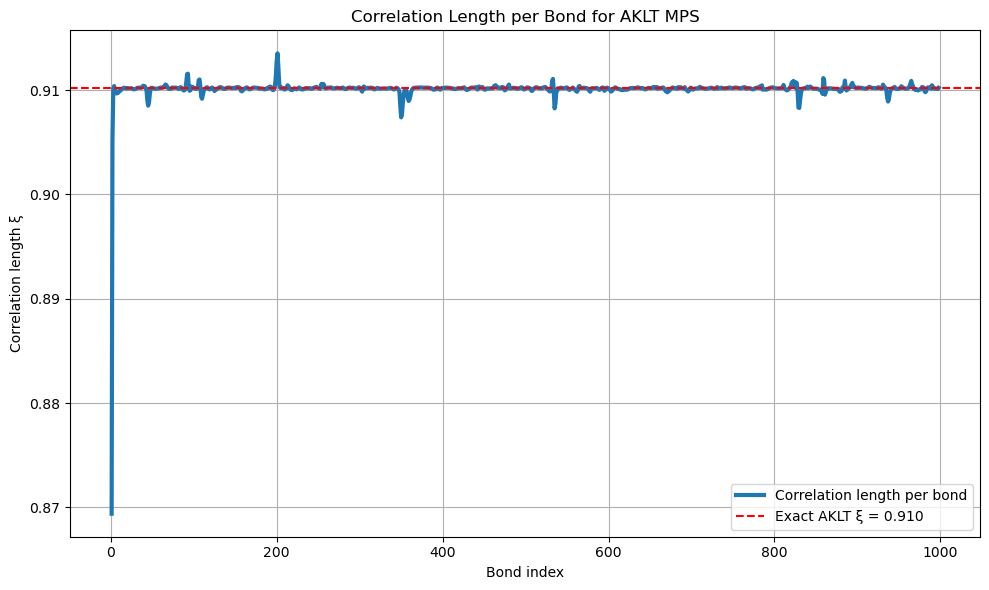

In [12]:
first_eigen, second_eigen, correlation_lengths= obj.full_chain_correlation_length()

xi_exact = 1 / np.log(3)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(correlation_lengths)+1), correlation_lengths, label='Correlation length per bond', linewidth=3)
plt.axhline(y=xi_exact, color='r', linestyle='--', label=f'Exact AKLT ξ = {xi_exact:.3f}')
plt.xlabel('Bond index')
plt.ylabel('Correlation length ξ')
plt.title('Correlation Length per Bond for AKLT MPS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

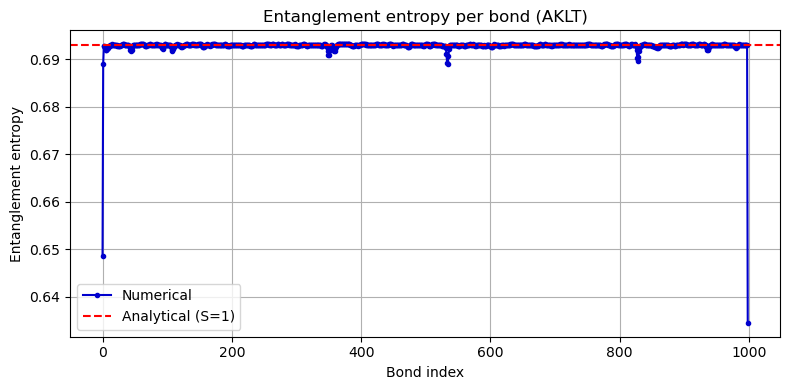

In [16]:
entropies = obj.all_bond_entropies()
bond_indices = np.arange(len(entropies))

plt.figure(figsize=(8, 4))
plt.plot(bond_indices, entropies, marker='.', linestyle='-', color='mediumblue', label='Numerical')
plt.axhline(y=0.693, color='red', linestyle='--', label='Analytical (S=1)')
plt.xlabel("Bond index")
plt.ylabel("Entanglement entropy")
plt.title("Entanglement entropy per bond (AKLT)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()